**1. Import and Pre-process Data:**

In [ ]:
# UPLOAD DATASETS:

from google.colab import files
uploaded = files.upload()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pprint import pprint

In [ ]:
movies_dataset = pd.read_csv('movies.csv')
ratings_dataset = pd.read_csv('ratings.csv')
tags_dataset = pd.read_csv('tags.csv')

print(movies_dataset.head())
print(ratings_dataset.head())
print(tags_dataset.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferre

In [ ]:
merged_dataset = pd.merge(ratings_dataset, movies_dataset[['movieId', 'title']], how='inner', on='movieId')
print(merged_dataset.head())

   userId  movieId  rating  timestamp                        title
0       1        1     4.0  964982703             Toy Story (1995)
1       1        3     4.0  964981247      Grumpier Old Men (1995)
2       1        6     4.0  964982224                  Heat (1995)
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)
4       1       50     5.0  964982931   Usual Suspects, The (1995)


**2. Temporal Encodings:**

In [ ]:
merged_dataset['timestamp'] = pd.to_datetime(merged_dataset['timestamp'], unit='s')

merged_dataset['hour'] = merged_dataset['timestamp'].dt.hour

merged_dataset['hour_sin'] = np.sin(merged_dataset['hour'] * (2 * np.pi / 24))
merged_dataset['hour_cos'] = np.cos(merged_dataset['hour'] * (2 * np.pi / 24))

print(merged_dataset[['hour', 'hour_sin', 'hour_cos']].head())

   hour  hour_sin      hour_cos
0    18 -1.000000 -1.836970e-16
1    18 -1.000000 -1.836970e-16
2    18 -1.000000 -1.836970e-16
3    19 -0.965926  2.588190e-01
4    18 -1.000000 -1.836970e-16


**3. Label Encodings:**

In [ ]:
user_enc = LabelEncoder()
merged_dataset['user'] = user_enc.fit_transform(merged_dataset['userId'])

movie_enc = LabelEncoder()
merged_dataset['movie'] = movie_enc.fit_transform(merged_dataset['title'])

n_users = merged_dataset['user'].nunique()
n_movies = merged_dataset['movie'].nunique()

print(n_users, n_movies)

610 9719


**4. Model Creation and Training:**

In [ ]:
X = merged_dataset[['user', 'movie', 'hour_sin', 'hour_cos']].values
y = merged_dataset['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 4), (10084, 4), (90752,), (10084,))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def create_model(input_shape):
    model = tf.keras.Sequential([
        # Input Layer
        layers.Input(shape=(input_shape,)),

        # First Dense Layer with BatchNormalization and LeakyReLU
        layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),

        # Dropout Layer
        layers.Dropout(0.3),

        # Second Dense Layer with BatchNormalization and LeakyReLU
        layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),

        # Third Dense Layer with BatchNormalization and LeakyReLU
        layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),

        # Output Layer
        layers.Dense(1, activation='linear')
    ])

    return model

model = create_model(X_train.shape[1])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,289 (173.00 KB)

 Trainable params: 43,393 (169.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True,
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),  # Try RMSprop
              loss='mean_squared_error',
              metrics=['mae'])
r
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.1914 - mae: 0.8374 - val_loss: 1.1795 - val_mae: 0.8378 - learning_rate: 1.0000e-04
Epoch 2/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.1834 - mae: 0.8383 - val_loss: 1.1681 - val_mae: 0.8288 - learning_rate: 1.0000e-04
Epoch 3/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.1744 - mae: 0.8348 - val_loss: 1.1656 - val_mae: 0.8288 - learning_rate: 1.0000e-04
Epoch 4/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.1558 - mae: 0.8313 - val_loss: 1.1602 - val_mae: 0.8369 - learning_rate: 1.0000e-04
Epoch 5/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.1581 - mae: 0.8337 - val_loss: 1.1544 - val_mae: 0.8325 - learning_rate: 1.0000e-04
Epoch 6/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.1580 - mae: 0.8352 - val_loss: 1.1487 - val_mae: 0.8344 - learning_rate: 1.0000e-04
Epoch 7/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.1439 - mae: 0.8316 - val_loss: 1.1440 - val_mae

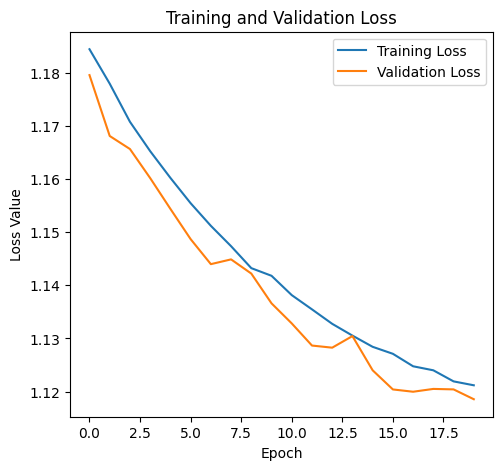

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

In [ ]:
def recommender_system(user_id, model, n_movies=5):
    encoded_user_id = user_enc.transform([user_id])

    # Get unseen movies
    seen_movies = list(merged_dataset[merged_dataset['userId'] == user_id]['movie'])
    unseen_movies = [i for i in range(n_movies) if i not in seen_movies]

    unseen_movies_sin = np.array([np.sin(12 * (2 * np.pi / 24)) for _ in unseen_movies])
    unseen_movies_cos = np.array([np.cos(12 * (2 * np.pi / 24)) for _ in unseen_movies])

    # Create model input as a single 2D array
    model_input = np.column_stack([
        np.repeat(encoded_user_id, len(unseen_movies)),
        unseen_movies,
        unseen_movies_sin,
        unseen_movies_cos
    ])

    predicted_ratings = model.predict(model_input)

    # Sort the movies based on predicted ratings
    sorted_index = np.argsort(predicted_ratings.flatten())[::-1]

    # Get recommended movie titles
    recommended_movies = movie_enc.inverse_transform(sorted_index)

    print("Top "+str(n_movies)+" Movie recommendations for User "+str(user_id)+":")
    pprint(list(recommended_movies[:n_movies]))

In [ ]:
user_id = int(input("Enter user id: "))
n_movies = int(input("Enter number of movies to be recommended: "))
recommender_system(user_id, model, n_movies)

Enter user id: 600
Enter number of movies to be recommended: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Top 15 Movie recommendations for User 600:
['1-900 (06) (1994)',
 '00 Schneider - Jagd auf Nihil Baxter (1994)',
 '...And Justice for All (1979)',
 '...All the Marbles (1981)',
 '*batteries not included (1987)',
 '(500) Days of Summer (2009)',
 "'night Mother (1986)",
 "'burbs, The (1989)",
 "'Tis the Season for Love (2015)",
 "'Til There Was You (1997)",
 "'Salem's Lot (2004)",
 "'Round Midnight (1986)",
 "'Hellboy': The Seeds of Creation (2004)",
 "'71 (2014)"]
